<a href="https://colab.research.google.com/github/Velociraptorvelraptor/agricultural_crops_img_classification/blob/main/Agricultural_crops_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle -q

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!mv /content/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mdwaquarazam/agricultural-crops-image-classification

In [ ]:
!unzip /content/agricultural-crops-image-classification.zip

In [146]:
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [96]:
transforms = T.Compose([
    T.Resize((150, 150)),
    T.CenterCrop(128),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

In [97]:
datafolder = ImageFolder('/content/Agricultural-crops', transforms)

In [98]:
datafolder

Dataset ImageFolder
    Number of datapoints: 829
    Root location: /content/Agricultural-crops
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(128, 128))
               RandomVerticalFlip(p=0.5)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [99]:
datafolder.classes

['Cherry',
 'Coffee-plant',
 'Cucumber',
 'Fox_nut(Makhana)',
 'Lemon',
 'Olive-tree',
 'Pearl_millet(bajra)',
 'Tobacco-plant',
 'almond',
 'banana',
 'cardamom',
 'chilli',
 'clove',
 'coconut',
 'cotton',
 'gram',
 'jowar',
 'jute',
 'maize',
 'mustard-oil',
 'papaya',
 'pineapple',
 'rice',
 'soyabean',
 'sugarcane',
 'sunflower',
 'tea',
 'tomato',
 'vigna-radiati(Mung)',
 'wheat']

In [100]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

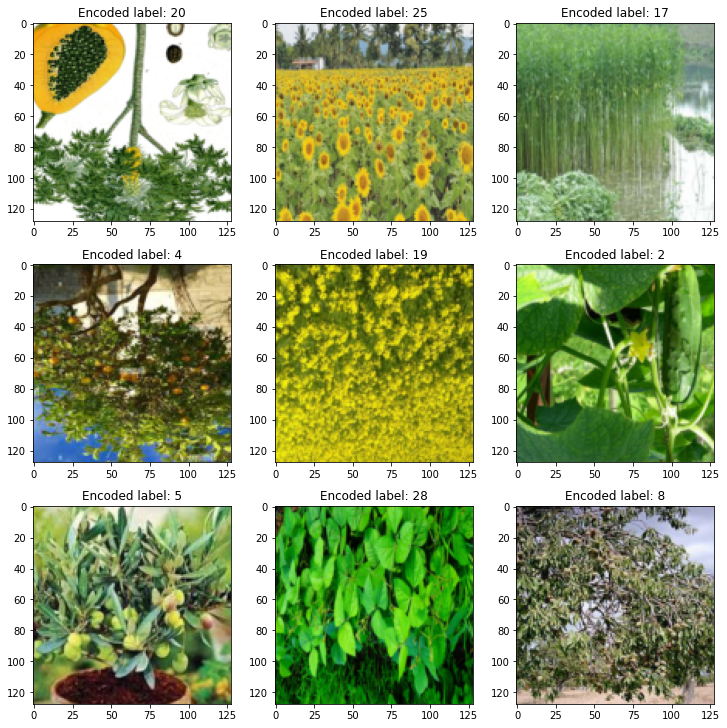

In [101]:
fig, axs = plt.subplots(3, 3, figsize=[10, 10], constrained_layout=True)
for i, ax in enumerate(axs.flat):
  k = random.randint(0, len(datafolder))
  img, label = datafolder.__getitem__(k) 
  ax.set_title(f'Encoded label: {label}')
  ax.imshow(img_display(img))
     

In [102]:
train_len = int(np.floor(len(datafolder) * 0.8))
val_len = int(len(datafolder) - train_len)

In [103]:
train_ds, val_ds = random_split(datafolder, [train_len, val_len])

In [140]:
train_dl = DataLoader(train_ds, 32, shuffle=False)
val_dl = DataLoader(val_ds, 32, shuffle=False)

In [161]:
#Benchmark model

class BenchmarkCNN(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2)
    self.drop = nn.Dropout(0.2)
    self.fc = nn.Linear(16 * 16 * 64, n_classes)

  def forward(self, x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    x = self.batchnorm1(x)
    x = F.relu(self.pool(self.conv3(x)))
    x = self.batchnorm2(x)
    x = F.dropout(self.drop(x), training=self.training)
    x = x.view(-1, 16 * 16 * 64)
    x = self.fc(x)
    return torch.log_softmax(x, dim=1)

In [162]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = BenchmarkCNN(n_classes=len(datafolder.classes)).to(device)

print(model)

BenchmarkCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=16384, out_features=30, bias=True)
)


In [166]:
def train(model, device, train_loader, loss_fn, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    correct = 0
    print("\nEpoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_fn(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target==predicted).item()
        acc = 100. * correct / len(train_loader.dataset)
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        #print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print(f'Train loss: {avg_loss:.5f}, acc: {acc:.2f}.')
    return avg_loss, acc

In [167]:
def test(model, device, test_loader, loss_fn):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_fn(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    acc = 100. * correct / len(test_loader.dataset)
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print(f'Test loss: {avg_loss:.5f}, acc: {acc:.2f}.')
    
    # return average loss for the epoch
    return avg_loss, acc

In [178]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_fn = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

epochs = 30
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_dl, loss_fn, optimizer, epoch)
    test_loss, test_acc = test(model, device, val_dl, loss_fn)
    epoch_nums.append(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Training on cuda

Epoch: 1


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(


Train loss: 1.51292, acc: 64.25.
Test loss: 7.48904, acc: 16.87.

Epoch: 2
Train loss: 1.64626, acc: 60.94.
Test loss: 7.30042, acc: 20.48.

Epoch: 3
Train loss: 1.27598, acc: 67.27.
Test loss: 6.09127, acc: 18.07.

Epoch: 4
Train loss: 1.21996, acc: 69.08.
Test loss: 4.83359, acc: 21.69.

Epoch: 5
Train loss: 1.08126, acc: 70.89.
Test loss: 5.54874, acc: 16.27.

Epoch: 6
Train loss: 0.95115, acc: 77.68.
Test loss: 4.39753, acc: 28.92.

Epoch: 7
Train loss: 0.86233, acc: 76.47.
Test loss: 5.78808, acc: 22.89.

Epoch: 8
Train loss: 0.88312, acc: 77.22.
Test loss: 4.53956, acc: 23.49.

Epoch: 9
Train loss: 0.89917, acc: 76.92.
Test loss: 4.99685, acc: 33.13.

Epoch: 10
Train loss: 0.84455, acc: 78.73.
Test loss: 5.26775, acc: 30.12.

Epoch: 11
Train loss: 0.66067, acc: 81.90.
Test loss: 4.29959, acc: 31.93.

Epoch: 12
Train loss: 0.50563, acc: 86.27.
Test loss: 5.84245, acc: 28.31.

Epoch: 13
Train loss: 0.62848, acc: 83.56.
Test loss: 5.72829, acc: 27.11.

Epoch: 14
Train loss: 0.53984,

In [179]:
metrics = pd.DataFrame({'epoch': epoch_nums,
                        'train_loss': train_losses,
                        'train_accuracy': train_accs,
                        'test_loss': test_losses,
                        'test_accuracy': test_accs})

In [180]:
metrics.head(5)

,epoch,train_loss,train_accuracy,test_loss,test_accuracy
0,1,1.512921,64.253394,7.489043,16.867470
1,2,1.646262,60.935143,7.300418,20.481928
2,3,1.275978,67.269985,6.091265,18.072289
3,4,1.219958,69.079940,4.833586,21.686747
4,5,1.081262,70.889894,5.548737,16.265060


In [191]:
def visualize(n, metric):
  axs[n].plot(metrics['epoch'], metrics[f'train_{metric}'], label=f'Training {metric}', ls='--')
  axs[n].plot(metrics['epoch'], metrics[f'test_{metric}'], label=f'Validation {metric}', ls='dotted')

  axs[n].set_title(f'Training and Validation {metric}')
  axs[n].set_xlabel('Epochs')
  axs[n].set_ylabel(metric)
  axs[n].legend()


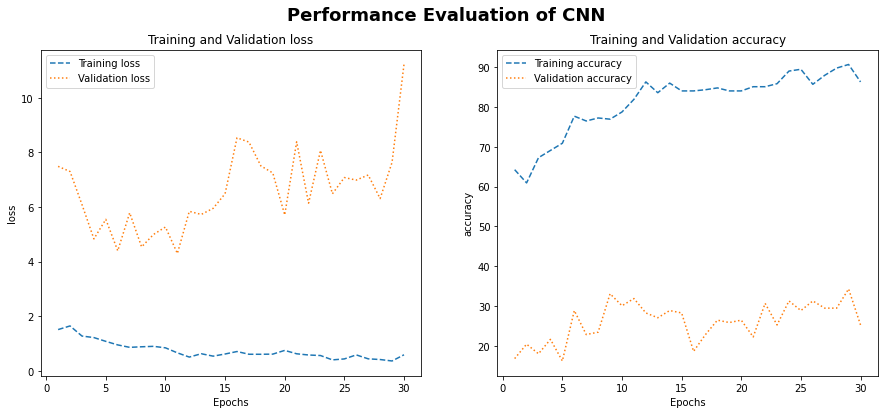

In [192]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
visualize(0, 'loss')
visualize(1, 'accuracy')
plt.suptitle(f"Performance Evaluation of CNN", fontsize=18, fontweight='bold')
plt.show()